<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Imports</h1>

In [61]:
import re
import ast
import nltk
import json
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import gensim.downloader as api
from nltk.corpus import stopwords
from tensorflow.keras import layers, Input 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import  Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout, Concatenate, GlobalMaxPooling1D
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [2]:
word2vec = api.load("word2vec-google-news-300")  
# nltk.download("punkt_tab")
# nltk.download("stopwords")
# nltk.download("wordnet")
# spacy.cli.download("en_core_web_sm")
# nltk.download('averaged_perceptron_tagger_eng')
# nlp = spacy.load("en_core_web_sm")

<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Constants and Global Variables</h1>

In [72]:
# text = pd.read_csv('Collected Datasets/text.csv')

EMOTIONS = ['happiness', 'neutral', 'sadness', 'anger', 'fear', ]
MAPPER = {emotion: [] for emotion in EMOTIONS}

scaler = StandardScaler()
encoder = LabelEncoder()
encoder.classes_ = np.array(EMOTIONS)

nlp = spacy.load("en_core_web_sm")
lemmatizer = nltk.WordNetLemmatizer()
STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS = STOP_WORDS.difference({'no', 'not', 'nor', 'never', "n't"})

MODELS = [layers.LSTM, layers.GRU, layers.SimpleRNN]
BATCH_SIZE = 32
EPOCHS = 10
POS_EMBED_DIM = 10
LSTM_UNITS = 128
DENSE_UNITS = 64
DROPOUT_RATE = 0.3
MAXLEN = 35


In [73]:
'''Emotional Lexicons'''
wordMap = pd.read_csv('wordMap.csv')
for emotion in wordMap.columns.to_list():
    words = [str(word).lower() for word in wordMap[emotion].dropna()]
    if emotion.lower() in EMOTIONS: MAPPER[emotion.lower()] = words
    if emotion in ['Calm', 'Boredom']: MAPPER['neutral'] += words   
    if emotion in ['Excitement', 'Pride']: MAPPER['happiness'] += words
    if emotion in ['Disgust', 'Frustration', 'Contempt']: MAPPER['anger'] += words

print(MAPPER)


{'happiness': ['joyful', 'ecstatic', 'content', 'cheerful', 'elated', 'delighted', 'pleased', 'radiant', 'euphoric', 'jovial', 'happy', 'merry', 'exuberant', 'overjoyed', 'satisfied', 'grateful', 'sunny', 'bubbly', 'lively', 'gleeful', 'glad', 'in high spirits', 'laughing', 'thrilled', 'blissful', 'carefree', 'exhilarated', 'optimistic', 'chipper', 'buoyant', 'uplifted', 'beaming', 'jubilant', 'proud', 'alive', 'zestful', 'lighthearted', 'upbeat', 'charmed', 'tickled pink', 'rapturous', 'in a good mood', 'on cloud nine', 'pumped', 'excited', 'grinning', 'eager', 'silly', 'pleased as punch', 'mirthful', 'vibrant', 'giddy', 'serene', 'festive', 'playful', 'contented', 'radiant', 'laughing fit', 'high-spirited', 'in a good place', 'carefree', 'light', 'breezy', 'sociable', 'enthusiastic', 'pleased with oneself', 'joyous', 'sweet', 'sanguine', 'delighted beyond words', 'up and about', 'full of life', 'tickled', 'exultant', 'bouncy', 'happy-go-lucky', 'energetic', 'on top of the world', 'hi

In [5]:
'''Contractions'''
with open("Common English Contractions/contractions.json" , 'r') as file:
    contractions = json.load(file)
    
contractions = pd.DataFrame(list(contractions.items()), columns=["Contraction", "Meaning"])
contractions = pd.concat([contractions, pd.read_csv("Common English Contractions/contractions.csv")], ignore_index=True)
contractions.drop_duplicates(inplace=True)
contractions["Contraction"] = contractions["Contraction"].str.lower()
contractions["Meaning"] = contractions["Meaning"].str.lower()
contractions.info()
contractions = contractions.set_index("Contraction").to_dict()["Meaning"]

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 0 to 262
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Contraction  195 non-null    object
 1   Meaning      195 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Cleaning and Preprocessing</h1>

<pre>
- All characters are lowercase
- No non alphabetic characters or numbers
</pre>

In [6]:
def encode(data, f="train"):
    if f == "train":
        data = encoder.fit_transform(data)
    else:
        data = encoder.transform(data)
    return data

In [35]:
def scale(data, f="train"):
    if f == "train":
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    return data

In [7]:
def filterByTextLength(data, minLen=5, maxLen=35):
    def _lengthFilter(text):
        if isinstance(text, str):
            length = len(text.split())
            return minLen <= length <= maxLen
        return False 
    
    filteredData = data[data["Text"].apply(_lengthFilter)].reset_index(drop=True)
    return filteredData

In [8]:
def expandContractions(data):
    count = 0
    for contraction, meaning in contractions.items():
        count += data['Text'].apply(lambda line: len(re.findall(rf'\b{contraction}\b', line))).sum()
        data['Text'] = data['Text'].apply(
            lambda line: re.sub(rf'\b{contraction}\b', meaning, line)
            )
        
    print("Number of contractions removed:", count)
    
    return data

In [9]:
def lexiconScore(data):
    for emotion, keywords in MAPPER.items():
        scores = []
        totalMatches = 0 
        for text in data['Text']:
            words = text.lower().split()
            counter = Counter(words)
            totalWords = len(words)
            score = sum(counter[word] for word in keywords)
            normalizedScore = score / totalWords if totalWords > 0 else 0.0
            scores.append(normalizedScore)
            totalMatches += score
            
        data[f"{emotion}Score"] = scores
        print(f"Total matched words for emotion '{emotion}': {totalMatches}")

        
    return data

In [10]:
def positionalTaggingAndTokenization(data):
    tokenizedTexts = []
    posTagsList = []
    
    for text in data["Text"]:
        doc = nlp(str(text))
        tokens = [token.text for token in doc]
        posTags = [token.pos_ for token in doc]
        
        tokenizedTexts.append(tokens)
        posTagsList.append(posTags)

    data["Text"] = tokenizedTexts
    data["posTag"] = posTagsList
    
    return data

In [11]:
def stopWordRemoval(data):
    filteredTexts = []
    filteredPOS = []
    
    for tokens, tags in zip(data["Text"], data["posTag"]):
        filteredTokens = []
        filteredTags = []
        
        for word, tag in zip(tokens, tags):
            if word.lower() not in STOP_WORDS:
                filteredTokens.append(word)
                filteredTags.append(tag)
        
        filteredTexts.append(filteredTokens)
        filteredPOS.append(filteredTags)
    
    data["Text"] = filteredTexts
    data["posTag"] = filteredPOS
    
    return data


In [12]:
def word2vecEmbedding(data, word2vec, vectorSize=300, maxLen=35):
    tokenizedTexts = data['Text'].tolist()
    zeroVector = np.zeros(vectorSize, dtype=np.float32)
    sequences = []

    for tokens in tokenizedTexts:
        wordVectors = [word2vec[word] for word in tokens if word in word2vec]
        padded = wordVectors[:maxLen] + [zeroVector] * max(0, maxLen - len(wordVectors))
        sequences.append(np.array(padded, dtype=np.float32)) 

    data['embeddings'] = sequences  
    return word2vec, data


In [13]:
def encodeAndPadPosTags(data, maxlen=35):
    allPosTags = [tag for seq in data['posTag'] for tag in seq]
    
    posEncoder = LabelEncoder()
    posEncoder.fit(allPosTags)
    
    encodedSequences = [posEncoder.transform(seq) for seq in data['posTag']]
    posPadded = pad_sequences(encodedSequences, maxlen=maxlen, padding='post', truncating='post')
    
    data['posPadded'] = list(posPadded)
    return data, posEncoder

<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">Saving Preprocessed Data</h1>

In [14]:
# text = filterByTextLength(text)
# text = expandContractions(text)
# text = lexiconScore(text)
# text = positionalTaggingAndTokenization(text)
# text = stopWordRemoval(text)

In [ ]:
def buildModel(maxlen, embeddingDim, posVocabSize, lexiconScoreDim, modelType):
    print(f"\nBuilding model with {modelType.__name__}")
    
    embeddingsInput = Input(shape=(maxlen, embeddingDim), name="embeddingsInput")
    posInput = Input(shape=(maxlen,), name="posInput")
    lexiconInput = Input(shape=(lexiconScoreDim,), name="lexiconInput")

    posEmbedding = Embedding(
        input_dim=posVocabSize, 
        output_dim=POS_EMBED_DIM,
        name="posEmbedding"
    )(posInput)

    embeddingsSeq = Bidirectional(
        modelType(LSTM_UNITS, return_sequences=True),
        name="rnnEmbedding"
    )(embeddingsInput)
    embeddingsSeq = GlobalMaxPooling1D()(embeddingsSeq)

    posSeq = Bidirectional(
        modelType(LSTM_UNITS, return_sequences=True),
        name="rnnPos"
    )(posEmbedding)
    posSeq = GlobalMaxPooling1D()(posSeq)

    features = Concatenate(name="features")([embeddingsSeq, posSeq, lexiconInput])

    features = Dense(DENSE_UNITS, activation="relu")(features)
    features = Dropout(DROPOUT_RATE)(features)
    output = Dense(5, activation="softmax", name="output")(features)

    model = Model(inputs=[embeddingsInput, posInput, lexiconInput], outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model, modelType.__name__


In [16]:
def evaluateModel(yTrue, yPred):
    print(classification_report(yTrue, yPred, target_names=EMOTIONS))

    accuracy = accuracy_score(yTrue, yPred)
    print(f"Accuracy: {accuracy:.4f}")

    precision = precision_score(yTrue, yPred, average="weighted")
    print(f"Precision: {precision:.4f}")

    recall = recall_score(yTrue, yPred, average="weighted")
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(yTrue, yPred, average="weighted")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(yTrue, yPred)
    print(f"Confusion Matrix:\n{cm}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [70]:
def train(model, xTrain, yTrain, xVal, yVal, name):
    print(f"\nTraining {name} model...")
    model.fit(
        [
           xTrain[0],
           xTrain[1],
           xTrain[2],
        ],
        yTrain,
        validation_data=(
            [
                xVal[0],
                xVal[1],
                xVal[2],
            ],
            yVal
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=True,
    )
    predictions = model.predict(xVal)
    predictions = np.argmax(predictions, axis=1)
    trueLabels = np.argmax(yVal, axis=1)
    evaluateModel(trueLabels, predictions)
    return model


In [ ]:
def compare(embeddingDim, posVocabSize, lexiconCols, xTrain, yTrain, xVal, yVal):
    for modelType in MODELS:
        model, name = buildModel(MAXLEN, embeddingDim, posVocabSize, len(lexiconCols), modelType)
        model = train(model, xTrain, yTrain, xVal , yVal, name)
        savePath = f"Models/{name}.h5"
        model.save(savePath)
        print(f"Model saved to {savePath}")

In [65]:
data = pd.read_csv("Preprocessed Data/processedText.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620227 entries, 0 to 620226
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Text            620227 non-null  object 
 1   Emotion         620227 non-null  object 
 2   happinessScore  620227 non-null  float64
 3   neutralScore    620227 non-null  float64
 4   sadnessScore    620227 non-null  float64
 5   angerScore      620227 non-null  float64
 6   fearScore       620227 non-null  float64
 7   posTag          620227 non-null  object 
dtypes: float64(5), object(3)
memory usage: 37.9+ MB


In [66]:
def stratifiedSample(data, labelColumn, samplesPerClass):
    return (
        data.groupby(labelColumn, group_keys=False)
        .apply(lambda x: x.sample(min(len(x), samplesPerClass), random_state=42))
        .reset_index(drop=True)
    )

data = stratifiedSample(data, labelColumn='Emotion', samplesPerClass=40000)
embedder, data = word2vecEmbedding(data, word2vec)


In [67]:
data.info()
csv = data.copy()
csv.to_csv("Preprocessed Data/processedTextLarge.csv", index=False)
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Text            200000 non-null  object 
 1   Emotion         200000 non-null  object 
 2   happinessScore  200000 non-null  float64
 3   neutralScore    200000 non-null  float64
 4   sadnessScore    200000 non-null  float64
 5   angerScore      200000 non-null  float64
 6   fearScore       200000 non-null  float64
 7   posTag          200000 non-null  object 
 8   embeddings      200000 non-null  object 
dtypes: float64(5), object(4)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Text            200000 non-null  object 
 1   Emotion         200000 non-null  object 
 2   happinessScore  200000 non-null 

In [68]:
def prepareData(data):
    data['posTag'] = data['posTag'].apply(ast.literal_eval)
    data, posEncoder = encodeAndPadPosTags(data)

    posVocabSize = len(posEncoder.classes_)
    embeddingDim = data['embeddings'][0].shape[1]
    lexiconCols = [f"{emotion}Score" for emotion in EMOTIONS]
    
    data[lexiconCols] = scale(data[lexiconCols], f="train")

    xEmbeddings = np.stack(data['embeddings'].to_numpy()).astype(np.float32)
    xPos = np.array(data['posPadded'].tolist())
    xLex = data[lexiconCols].values

    labelEncoder = LabelEncoder()
    yEncoded = labelEncoder.fit_transform(data['Emotion'])
    yCategorical = to_categorical(yEncoded)

    xTrainEmbed, xValEmbed, xTrainPos, xValPos, xTrainLex, xValLex, yTrain, yVal = train_test_split(
        xEmbeddings, xPos, xLex, yCategorical, test_size=0.2, random_state=42
    )
    
    xTrain = [xTrainEmbed, xTrainPos, xTrainLex]
    xVal = [xValEmbed, xValPos, xValLex]
    return xTrain, yTrain, xVal, yVal, embeddingDim, posVocabSize, lexiconCols


xTrain, yTrain, xVal, yVal, embeddingDim, posVocabSize, lexiconCols = prepareData(data)


Building model with LSTM
embeddingsSeq shape: (None, 256)
posSeq shape: (None, 256)
lexiconInput shape: (None, 5)
Concatenated feature shape: (None, 517)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ posInput            │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingsInput     │ (None, 35, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ posEmbedding        │ (None, 35, 10)    │        170 │ posInput[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnEmbedding        │ (None, 35, 256)   │    439,296 │ embeddingsInput[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnPos              │ (None, 35, 256)   │    142,336 │ posEmbedding[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnEmbedding[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnPos[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lexiconInput        │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 517)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ lexiconInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     33,152 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │        325 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 615,279 (2.35 MB)

 Trainable params: 615,279 (2.35 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddingsInput', 'posInput', 'lexiconInput']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1125s 224ms/step - accuracy: 0.4776 - loss: 1.2812 - val_accuracy: 0.6478 - val_loss: 0.8825
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1111s 222ms/step - accuracy: 0.6566 - loss: 0.8704 - val_accuracy: 0.6762 - val_loss: 0.8009
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1089s 218ms/step - accuracy: 0.6798 - loss: 0.7925 - val_accuracy: 0.6841 - val_loss: 0.7742
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1146s 229ms/step - accuracy: 0.6904 - loss: 0.7604 - val_accuracy: 0.6883 - val_loss: 0.7541
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1128s 226ms/step - accuracy: 0.6953 - loss: 0.7386 - val_accuracy: 0.6903 - val_loss: 0.7474
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1182s 236ms/step - accuracy: 0.7040 - loss: 0.7214 - val_accuracy: 0.6926 - val_loss: 0.7382
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1156s 231ms/step - accuracy: 0.7044 - loss: 0.7141 - val_accuracy: 0.6933 - val_loss: 0.7377
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1244s 249ms/step - accur

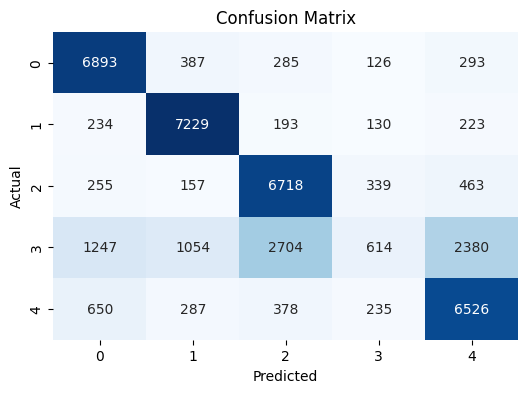


Building model with GRU
embeddingsSeq shape: (None, 256)
posSeq shape: (None, 256)
lexiconInput shape: (None, 5)
Concatenated feature shape: (None, 517)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ posInput            │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingsInput     │ (None, 35, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ posEmbedding        │ (None, 35, 10)    │        170 │ posInput[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnEmbedding        │ (None, 35, 256)   │    330,240 │ embeddingsInput[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnPos              │ (None, 35, 256)   │    107,520 │ posEmbedding[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnEmbedding[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnPos[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lexiconInput        │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 517)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ lexiconInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     33,152 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │        325 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 471,407 (1.80 MB)

 Trainable params: 471,407 (1.80 MB)

 Non-trainable params: 0 (0.00 B)


Training GRU model...
Epoch 1/10


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddingsInput', 'posInput', 'lexiconInput']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1359s 271ms/step - accuracy: 0.4643 - loss: 1.2997 - val_accuracy: 0.6276 - val_loss: 0.9507
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1462s 292ms/step - accuracy: 0.6308 - loss: 0.9384 - val_accuracy: 0.6523 - val_loss: 0.8689
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1309s 262ms/step - accuracy: 0.6593 - loss: 0.8547 - val_accuracy: 0.6686 - val_loss: 0.8188
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1462s 292ms/step - accuracy: 0.6757 - loss: 0.8107 - val_accuracy: 0.6763 - val_loss: 0.8064
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1325s 265ms/step - accuracy: 0.6802 - loss: 0.7927 - val_accuracy: 0.6819 - val_loss: 0.7832
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1494s 299ms/step - accuracy: 0.6860 - loss: 0.7759 - val_accuracy: 0.6853 - val_loss: 0.7739
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1376s 275ms/step - accuracy: 0.6900 - loss: 0.7603 - val_accuracy: 0.6795 - val_loss: 0.7773
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1500s 300ms/step - accur

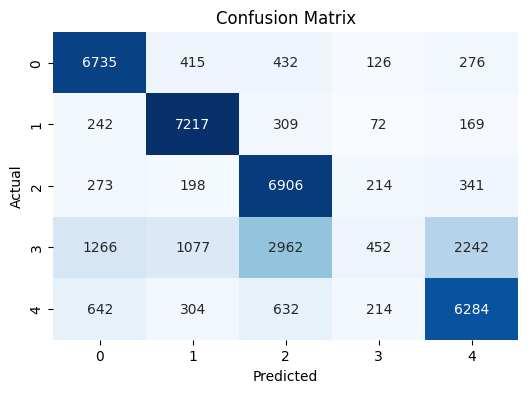


Building model with SimpleRNN
embeddingsSeq shape: (None, 256)
posSeq shape: (None, 256)
lexiconInput shape: (None, 5)
Concatenated feature shape: (None, 517)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ posInput            │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingsInput     │ (None, 35, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ posEmbedding        │ (None, 35, 10)    │        170 │ posInput[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnEmbedding        │ (None, 35, 256)   │    109,824 │ embeddingsInput[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnnPos              │ (None, 35, 256)   │     35,584 │ posEmbedding[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnEmbedding[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ rnnPos[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lexiconInput        │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 517)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ lexiconInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │     33,152 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │        325 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 179,055 (699.43 KB)

 Trainable params: 179,055 (699.43 KB)

 Non-trainable params: 0 (0.00 B)


Training SimpleRNN model...
Epoch 1/10


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddingsInput', 'posInput', 'lexiconInput']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 518s 103ms/step - accuracy: 0.4316 - loss: 1.3503 - val_accuracy: 0.6183 - val_loss: 0.9813
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 512s 102ms/step - accuracy: 0.5982 - loss: 1.0317 - val_accuracy: 0.6456 - val_loss: 0.8961
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 492s 98ms/step - accuracy: 0.6197 - loss: 0.9639 - val_accuracy: 0.6382 - val_loss: 0.8917
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 510s 102ms/step - accuracy: 0.6233 - loss: 0.9509 - val_accuracy: 0.6600 - val_loss: 0.8486
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 499s 100ms/step - accuracy: 0.6416 - loss: 0.9121 - val_accuracy: 0.6644 - val_loss: 0.8302
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 516s 103ms/step - accuracy: 0.6463 - loss: 0.8936 - val_accuracy: 0.6624 - val_loss: 0.8592
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 506s 101ms/step - accuracy: 0.6507 - loss: 0.8879 - val_accuracy: 0.6669 - val_loss: 0.8430
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 525s 105ms/step - accuracy: 0.65

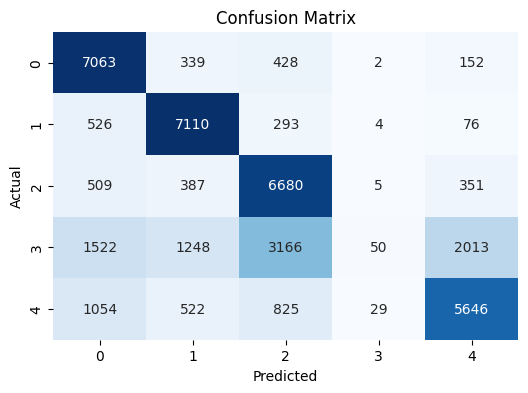

In [74]:
compare(embeddingDim, posVocabSize, lexiconCols, xTrain, yTrain, xVal, yVal)
